# Libraries

In [ ]:
!pip install gymnasium

# GYM Environment

In [ ]:
import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import FlattenObservation

np.random.seed(353)

class DiscretizedObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_bins=5, low=None, high=None):
        super().__init__(env)
        assert isinstance(env.observation_space, spaces.Box)

        '''
        low = self.observation_space.low if low is None else low
        high = self.observation_space.high if high is None else high

        self.n_bins = n_bins
        self.val_bins = [np.linspace(l, h, n_bins + 1) for l, h in zip(low.flatten(), high.flatten())]
        self._max_ = round(sum([d * ((self.n_bins + 1) ** i) for i, d in enumerate(high)])) + 1
        self.observation_space = spaces.Discrete(self._max_)
        '''
        self.observation_space = spaces.Discrete(6*4**0 + 6*4**1 + 6*4**2 + 6*4**3)

    def _convert_to_one_number(self, digits):
        return sum([d * ((self.n_bins + 1) ** i) for i, d in enumerate(digits)])

    def observation(self, obs):
        '''
        digits = [np.digitize([x], bins)[0] - 1 for x, bins in zip(observation, self.val_bins)]
        r = self._convert_to_one_number(digits)
        '''

        return obs[0] * 4 ** 0 + obs[1] * 4 ** 1 + obs[2] * 4 ** 2 + obs[3] * 4 ** 3


    def get_transition_matrix(self):
        # Generate transition dynamics similar to 'P' in standard Gym environments
        num_states = self.observation_space.n
        num_actions = self.action_space.n
        P = {s: {a: [] for a in range(num_actions)} for s in range(num_states)}

        for s in range(num_states):
            for a in range(num_actions):
                next_states = self.get_possible_next_states(s, a)
                for next_state, prob, reward, terminated, truncated, _ in next_states:
                    P[s][a].append((next_state, prob, reward, terminated, truncated, {}))

        return P

    ''' NOTE: This function can use improvements for more accurate results for VI '''
    def get_possible_next_states(self, state, action):
        next_states = []

        for wind_idx, wind_prob in enumerate((0.1, 0.1, 0.80)):
          direction = self.action_to_direction[action]

          if wind_idx == 0:
            direction = np.array((0, 0))
          if wind_idx == 1:
            direction *= -1

          new_agent_location = np.clip(self.agent_location + direction, 0, 5)

          distance_to_target = np.linalg.norm(new_agent_location - self.target_location, ord=1)
          distances_to_blockades = [np.linalg.norm(new_agent_location - blockade, ord=1) for blockade in self.blockade_locations]

          obs = list(new_agent_location.astype(int)) + list(self.target_location.astype(int))

          '''
          digits = [np.digitize([x], bins)[0] - 1 for x, bins in zip(obs, self.val_bins)]
          next_state = self._convert_to_one_number(digits)
          '''
          next_state = obs[0] * 4 ** 0 + obs[1] * 4 ** 1 + obs[2] * 4 ** 2 + obs[3] * 4 ** 3

          reward, terminated, truncated, reward_prob = self.reward(direction)

          prob = 1.0 * wind_prob * reward_prob

          next_states.append((next_state, prob, reward, terminated, truncated, {}))

        return next_states

def normpdf(x, avg=0, std=1):
    exp = np.exp(-0.5 * ((x - avg) / std) ** 2)
    pdf = (1 / (std * np.sqrt(2 * np.pi)) * exp)
    return pdf

class GridWorldEnv(gym.Env):
    def __init__(self):

        '''
                "blockades": spaces.Tuple(spaces.Box(0, 5, shape=(2,), dtype=int) for _ in range(8)),
                "agent_health":  spaces.Box(0, 1),
                "agent_battery":  spaces.Box(0, 1),
                "base": spaces.Box(0, 5, shape=(2,), dtype=int), # 36
                "distance_to_base": spaces.Box(0, 6 * np.sqrt(2)),
                "distance_to_target": spaces.Box(0, 6 * np.sqrt(2)),
                "min_distance_to_blockade": spaces.Box(0, 6 * np.sqrt(2)),
        '''
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, 5, shape=(2,), dtype=int), # 36
                "target": spaces.Box(0, 5, shape=(2,), dtype=int), # 36
            }
        )

        self.action_space = spaces.Discrete(4)

        self.action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

    def _get_obs(self):
      distances = [np.linalg.norm(self.agent_location - blockade, ord=1) for blockade in self.blockade_locations]

      '''
          "blockades": self.blockade_locations,
          "base": self._base_location,
          "agent_health": self._agent_health,
          "agent_battery": self._agent_battery,
          "distance_to_base": np.linalg.norm(
              self.agent_location - self._base_location, ord=1
          ),
          "distance_to_target": np.linalg.norm(
              self.agent_location - self.target_location, ord=1
          ),
          "min_distance_to_blockade": np.min(distances),
      '''
      return {
          "agent": self.agent_location,
          "target": self.target_location,
      }

    def _idx_to_cord(self, idx):
      return np.array((idx // 6, idx % 6))

    def reset(self, seed=None, options=None):
      super().reset(seed=seed)

      self._agent_health = 1
      self._agent_battery = 1

      agent = self.np_random.choice([12, 7, 6, 2, 1, 0])
      target = self.np_random.choice([35, 34, 33, 29, 28, 23])

      self.agent_location = self._idx_to_cord(agent)
      self._base_location = self.agent_location
      self.target_location = self._idx_to_cord(target)

      available_spaces = set(range(36)) - {agent, target}
      border_space = {0, 1, 2, 3, 4, 5, 6, 11, 12, 17, 18, 23, 24, 29, 30, 31, 32, 33, 34, 35} - {agent, target}
      border_blockades = 0

      self.blockade_locations = []
      for _ in range(8):
        c = self.np_random.choice(tuple(available_spaces))

        if c in border_space:
          border_blockades += 1

        if border_blockades > 2:
          while c in border_space:
            c = self.np_random.choice(tuple(available_spaces))

        self.blockade_locations.append(self._idx_to_cord(c))

        available_spaces -= {c}
      self.blockade_locations = np.array(self.blockade_locations)

      observation = self._get_obs()

      self.steps = 0

      return observation, None

    def reward(self, direction):
      reward = 0
      reward_prob = 1

      if any([np.array_equal(self.agent_location + direction, blockade) for blockade in self.blockade_locations]):
        x = self.np_random.normal(-1, 0.5)
        reward += x
        reward_prob *= normpdf(x, -1, 0.5)

        x = self.np_random.normal(0.2, 0.1)
        self._agent_health -= x
        reward_prob *= normpdf(x, 0.2, 0.1)
      else:
        x = self.np_random.normal(-0.5, 0.25)
        reward += x
        reward_prob *= normpdf(x, -0.5, 0.25)

        self.agent_location = np.clip(
            self.agent_location + direction, 0, 6
        )

        x = self.np_random.normal(0.35, 0.15)
        self._agent_battery -= x
        reward_prob *= normpdf(x, 0.35, 0.15)

      if np.array_equal(self._base_location, self.agent_location):
        if self._agent_battery < 5:
          x = self.np_random.normal(5, 0.1)
          reward += x
          reward_prob *= normpdf(x, 5, 0.1)
          self._agent_battery = 1
        if self._agent_battery < 15:
          x = self.np_random.normal(5, 0.1)
          reward += x
          reward_prob *= normpdf(x, 5, 0.1)
          self._agent_health = 1

      terminated = np.array_equal(self.agent_location, self.target_location)
      if terminated:
        x = self.np_random.normal(25, 5)
        reward += x
        reward_prob *= normpdf(x, 25, 5)

      truncated = self._agent_battery < 0 or self._agent_battery < 0
      if self.steps > 500:
        truncated = True

      if truncated:
        x = self.np_random.normal(-10, 5)
        reward += x
        reward_prob *= normpdf(x, -10, 5)

      return reward, terminated, truncated, reward_prob

    #(observation, reward, terminated, truncated)
    def step(self, action):
      direction = self.action_to_direction[action]
      wind_prob = self.np_random.random()

      if 0 <= wind_prob and wind_prob <= 10:
        direction *= -1
      if 10 < wind_prob and wind_prob <= 20:
        direction = np.array([0, 0])

      reward, terminated, truncated, _ = self.reward(direction)

      observation = self._get_obs()

      self.steps += 1


      return observation, reward, terminated, truncated, None

world = DiscretizedObservationWrapper(FlattenObservation(GridWorldEnv()))
world.reset(seed=315)
world.observation_space.n

510

# Hyper parameters

(0.0, 750.0)

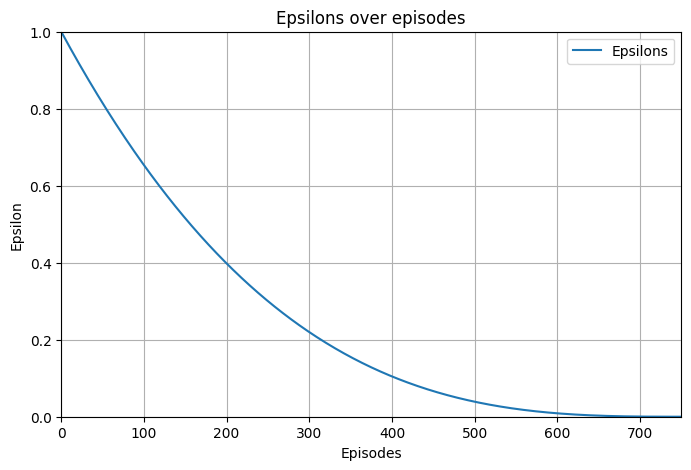

In [ ]:
alpha = 0.1
gamma = 0.9

min_eps = 0.01
max_eps = 1.0
episodes = 750
iters = 10
seeds = np.random.randint(int(1e10), size=(iters, episodes))

epsilons = np.linspace(max_eps, min_eps, episodes) ** 3

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(epsilons, label="Epsilons")
plt.title('Epsilons over episodes')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 1])
ax.set_xlim([0, episodes])

# Q-Learning Fixed learning rate

In [ ]:
max_fixed_rewards  = np.array([-np.inf] * episodes)
mean_fiexd_rewards = np.zeros(episodes)

for j in range(iters):
  q_table = np.zeros([world.observation_space.n, world.action_space.n])
  episode_rewards = []

  for i in range(episodes):
      state, _ = world.reset(seed=int(seeds[j][i]))

      reward, episode_reward = 0, 0
      done = truncated = False

      epsilon = epsilons[i]

      while not (done or truncated):
          if np.random.uniform(0, 1) < epsilon:
              action = world.action_space.sample()
          else:
              action = np.argmax(q_table[state])

          next_state, reward, done, truncated, _ = world.step(action)

          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])

          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          state = next_state

          episode_reward += reward

      episode_rewards.append(episode_reward)

  episode_rewards = np.array(episode_rewards)
  max_fixed_rewards = np.maximum(episode_rewards, max_fixed_rewards)
  mean_fiexd_rewards = np.add(episode_rewards, mean_fiexd_rewards)

mean_fiexd_rewards *= 1 / iters

# Q-Learning Moving learning rate

In [ ]:
min_alpha = 0.1
max_alpha = 0.9

alphas = np.linspace(max_alpha, min_alpha, episodes) ** 2

max_moving_rewards = np.array([-np.inf] * episodes)
mean_moving_rewards = np.zeros(episodes)

for j in range(iters):
  q_table = np.zeros([world.observation_space.n, world.action_space.n])
  episode_rewards = []

  for i in range(episodes):
      state, _ = world.reset(seed=int(seeds[j][i]))

      reward, episode_reward = 0, 0
      done = truncated = False

      epsilon = epsilons[i]
      alpha = alphas[i]

      while not (done or truncated):
          if np.random.uniform(0, 1) < epsilon:
              action = world.action_space.sample()
          else:
              action = np.argmax(q_table[state])

          next_state, reward, done, truncated, _ = world.step(action)

          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])

          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          state = next_state

          episode_reward += reward

      episode_rewards.append(episode_reward)
  episode_rewards = np.array(episode_rewards)
  max_moving_rewards = np.maximum(episode_rewards, max_moving_rewards)
  mean_moving_rewards = np.add(episode_rewards, mean_moving_rewards)

mean_moving_rewards *= 1 / iters

# Q-Learning Results

(0.0, 750.0)

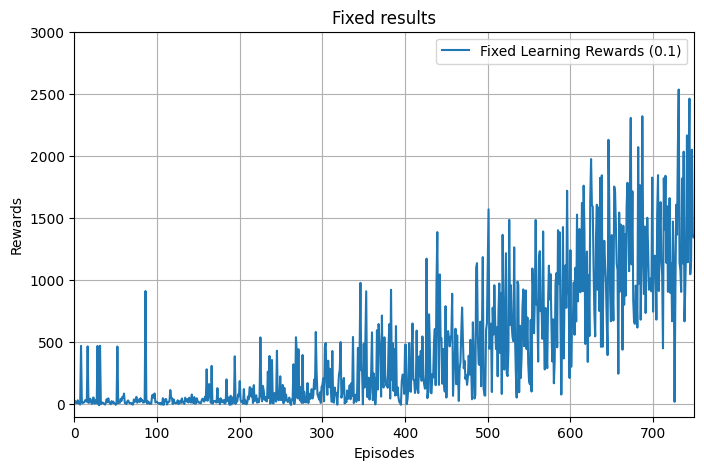

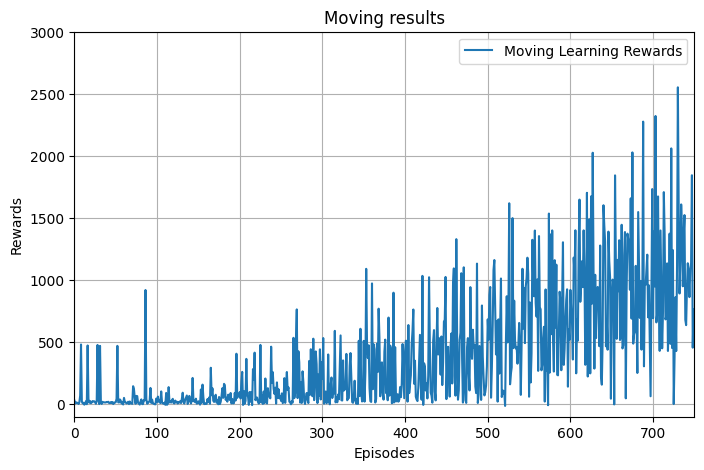

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(mean_fiexd_rewards, label="Fixed Learning Rewards (0.1)")
plt.title('Fixed results')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-100, 3000])
ax.set_xlim([0, episodes])

plt.figure(figsize=(8, 5))
plt.plot(mean_moving_rewards, label="Moving Learning Rewards")
plt.title('Moving results')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-100, 3000])
ax.set_xlim([0, episodes])

# SARSA

In [ ]:
mean_sarsa_rewards = np.zeros(episodes)
max_sarsa_rewards = np.array([-np.inf] * episodes)

for j in range(iters):
  q_table = np.zeros([world.observation_space.n, world.action_space.n])

  episode_rewards = []

  for i in range(episodes):
      state, _ = world.reset(seed=int(seeds[j][i]))

      reward, episode_reward = 0, 0
      done = truncated = False

      epsilon = epsilons[i]

      while not (done or truncated):
          if np.random.uniform(0, 1) < epsilon:
              action = world.action_space.sample()
          else:
              action = np.argmax(q_table[state])

          next_state, reward, done, truncated, _ = world.step(action)

          predict = q_table[state, action]
          target = reward + gamma * q_table[state, action]
          q_table[state, action] = predict + alpha * (target - predict)

          state = next_state

          episode_reward += reward

      episode_rewards.append(episode_reward)
  max_sarsa_rewards = np.maximum(episode_rewards, max_sarsa_rewards)
  mean_sarsa_rewards = np.add(episode_rewards, mean_sarsa_rewards)

mean_sarsa_rewards *= 1 / iters

(0.0, 750.0)

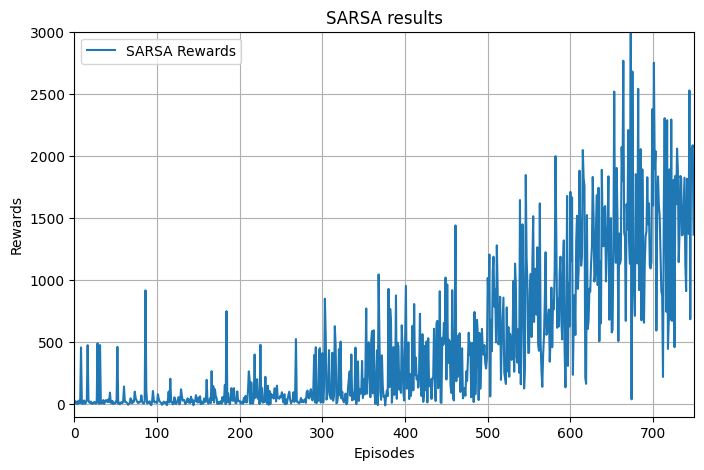

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.plot(mean_sarsa_rewards, label="SARSA Rewards")
plt.title(f"SARSA results")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-100, 3000])
ax.set_xlim([0, episodes])

# Tree backup n-step

In [ ]:
results = {}

for n in [2, 3, 4, 5]:
  mean_nstep_tree_rewards = np.zeros(episodes)
  max_nstep_tree_rewards = np.array([-np.inf] * episodes)

  for j in range(iters):
    q_table = np.zeros([world.observation_space.n, world.action_space.n])

    episode_rewards = []

    for i in range(episodes):
        steps = []
        state, _ = world.reset(seed=int(seeds[j][i]))

        reward, episode_reward = 0, 0
        done = truncated = False

        epsilon = epsilons[i]

        while not (done or truncated):
            if np.random.uniform(0, 1) < epsilon:
                action = world.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, truncated, _ = world.step(action)
            steps.append((state, action, next_state, reward))
            state = next_state
            episode_reward += reward

            if len(steps) >= n:
              G = 0
              t = len(steps) - n

              for i in range(len(steps)-1, t-1, -1):
                  G += gamma**(i-t) * steps[i][3]

              state_t, action_t, next_state_t, _ = steps[t-1]
              Q_target = 0

              if not (done or truncated):
                  Q_target = gamma**n * q_table[next_state_t][np.argmax(q_table[state])]

              q_table[state_t][action_t] += alpha * (G + Q_target - q_table[state_t][action_t])


        episode_rewards.append(episode_reward)
    max_nstep_tree_rewards = np.maximum(episode_rewards, max_nstep_tree_rewards)
    mean_nstep_tree_rewards = np.add(episode_rewards, mean_nstep_tree_rewards)

  mean_nstep_tree_rewards *= 1 / iters
  results[n] = mean_nstep_tree_rewards

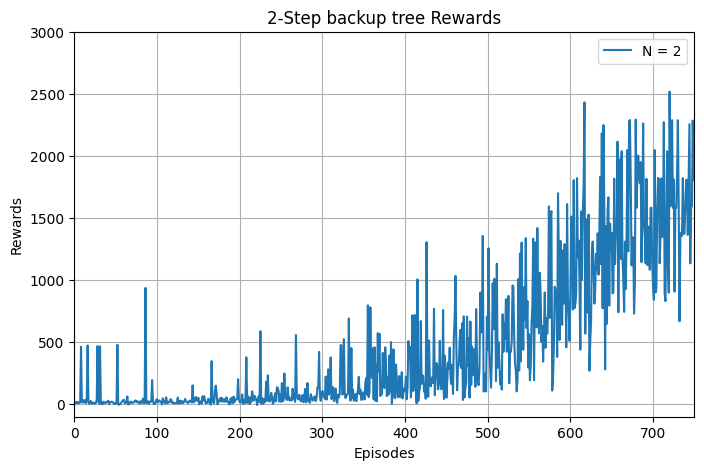

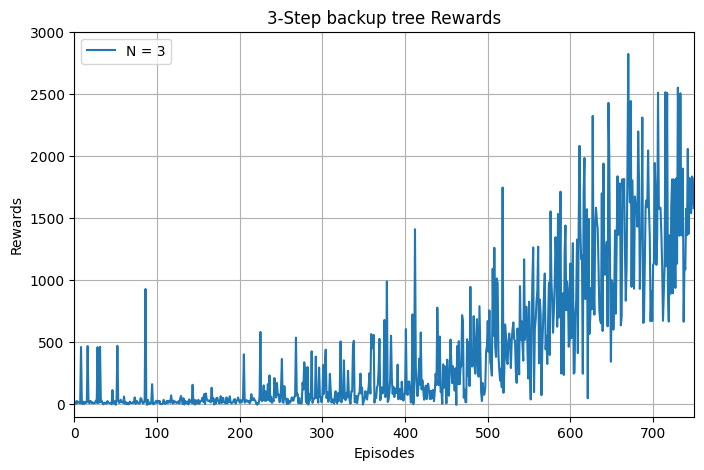

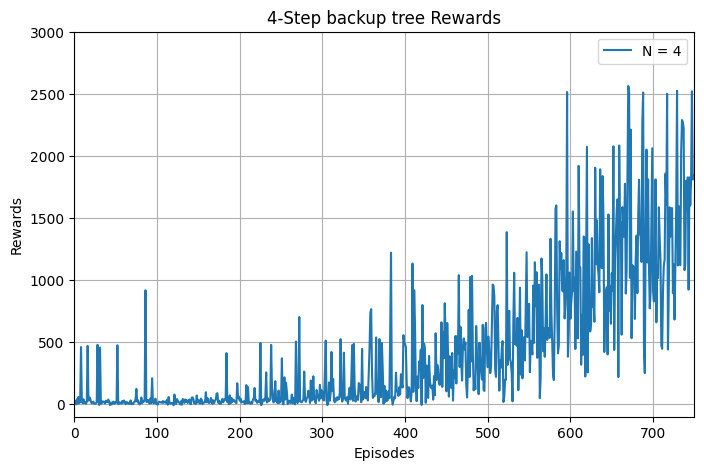

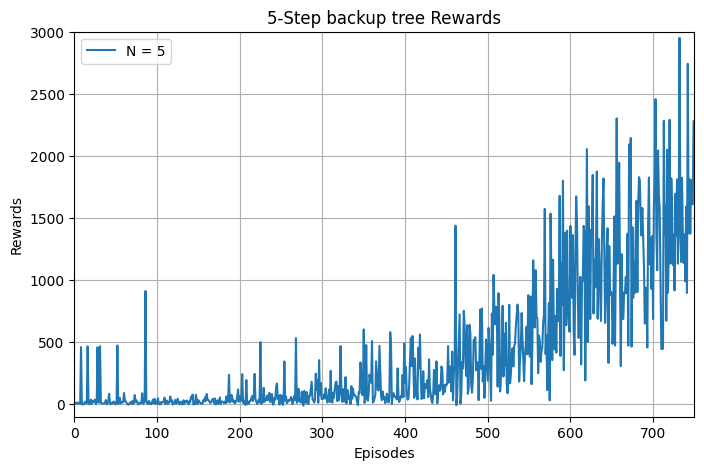

In [ ]:
import matplotlib.pyplot as plt


for i, (k, v) in enumerate(results.items()):
  plt.figure(figsize=(8, 5))
  plt.plot(v, label=f"N = {k}")
  plt.title(f'{k}-Step backup tree Rewards')
  plt.xlabel('Episodes')
  plt.ylabel('Rewards')
  plt.legend()
  plt.grid()
  ax = plt.gca()
  ax.set_ylim([-100, 3000])
  ax.set_xlim([0, episodes])

# Off-Policy MC

In [ ]:
mean_mc_rewards = np.zeros(episodes)
max_mc_rewards = np.array([-np.inf] * episodes)

for j in range(iters):
    Q = np.zeros((world.observation_space.n, world.action_space.n))
    C = np.zeros((world.observation_space.n, world.action_space.n))  # Importance Sampling Ratio
    episode_rewards = []

    for i in range(episodes):
        state, _ = world.reset(seed=int(seeds[j][i]))
        done = truncated = False
        states, actions, rewards = [], [], []

        while not (done or truncated):
            # Off-policy: Choose actions using a behavior policy (e.g., ε-greedy)
            if np.random.uniform(0, 1) < epsilons[i]:
                action = world.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = world.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        G = 0  # Initialize return
        importance_sampling_ratio = 1.0  # Initialize importance sampling ratio

        # Calculate returns and update Q-values using Q-learning
        for t in reversed(range(len(states))):
            state = states[t]
            action = actions[t]
            reward = rewards[t]

            G = reward + gamma * G  # Discounted return

            # Off-policy update using Q-learning
            C[state][action] += importance_sampling_ratio
            Q[state][action] += (importance_sampling_ratio / C[state][action]) * (G - Q[state][action])

            if action != np.argmax(Q[state]):  # Check if the behavior policy would have taken a different action
                break  # If so, terminate the loop for importance sampling ratio calculation

            # Update importance sampling ratio based on the target and behavior policies
            behavior_prob = 1.0 if epsilons[i] < 1.0 else epsilons[i] / world.action_space.n
            target_prob = 1.0 if action == np.argmax(Q[state]) else (1.0 - epsilons[i]) + (epsilons[i] / world.action_space.n)
            importance_sampling_ratio *= target_prob / behavior_prob

        episode_rewards.append(np.sum(rewards))

    max_mc_rewards = np.maximum(episode_rewards, max_mc_rewards)
    mean_mc_rewards = np.add(episode_rewards, mean_mc_rewards)

mean_mc_rewards *= 1 / iters

(0.0, 750.0)

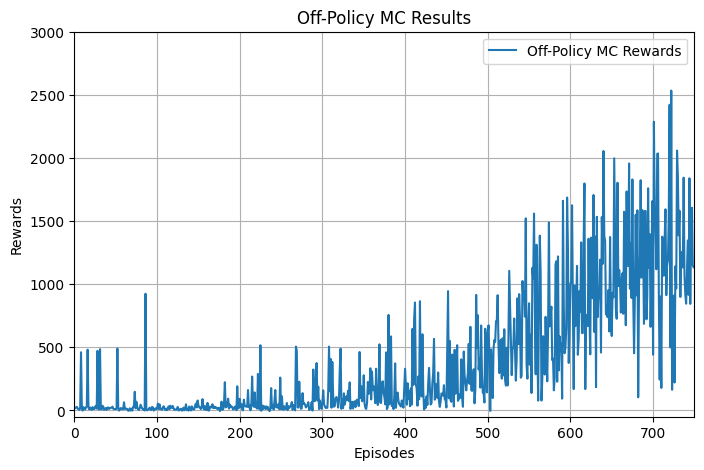

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.plot(mean_mc_rewards, label="Off-Policy MC Rewards")
plt.title(f"Off-Policy MC Results")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-50, 3000])
ax.set_xlim([0, episodes])

# Fixed Epsilon MC

In [ ]:
mean_mc_rewards = np.zeros(episodes)
max_mc_rewards = np.array([-np.inf] * episodes)

for j in range(iters):
    Q = np.zeros((world.observation_space.n, world.action_space.n))
    C = np.zeros((world.observation_space.n, world.action_space.n))  # Importance Sampling Ratio
    episode_rewards = []

    for i in range(episodes):
        state, _ = world.reset(seed=int(seeds[j][i]))
        done = truncated = False
        states, actions, rewards = [], [], []

        while not (done or truncated):
            # Off-policy: Choose actions using a behavior policy (e.g., ε-greedy)
            if np.random.uniform(0, 1) < 0.1:
                action = world.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = world.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        G = 0  # Initialize return
        importance_sampling_ratio = 1.0  # Initialize importance sampling ratio

        # Calculate returns and update Q-values using Q-learning
        for t in reversed(range(len(states))):
            state = states[t]
            action = actions[t]
            reward = rewards[t]

            G = reward + gamma * G  # Discounted return

            # Off-policy update using Q-learning
            C[state][action] += importance_sampling_ratio
            Q[state][action] += (importance_sampling_ratio / C[state][action]) * (G - Q[state][action])

            if action != np.argmax(Q[state]):  # Check if the behavior policy would have taken a different action
                break  # If so, terminate the loop for importance sampling ratio calculation

            # Update importance sampling ratio based on the target and behavior policies
            behavior_prob = 1.0 if epsilons[i] < 1.0 else epsilons[i] / world.action_space.n
            target_prob = 1.0 if action == np.argmax(Q[state]) else (1.0 - epsilons[i]) + (epsilons[i] / world.action_space.n)
            importance_sampling_ratio *= target_prob / behavior_prob

        episode_rewards.append(np.sum(rewards))

    max_mc_rewards = np.maximum(episode_rewards, max_mc_rewards)
    mean_mc_rewards = np.add(episode_rewards, mean_mc_rewards)

mean_mc_rewards *= 1 / iters

(0.0, 750.0)

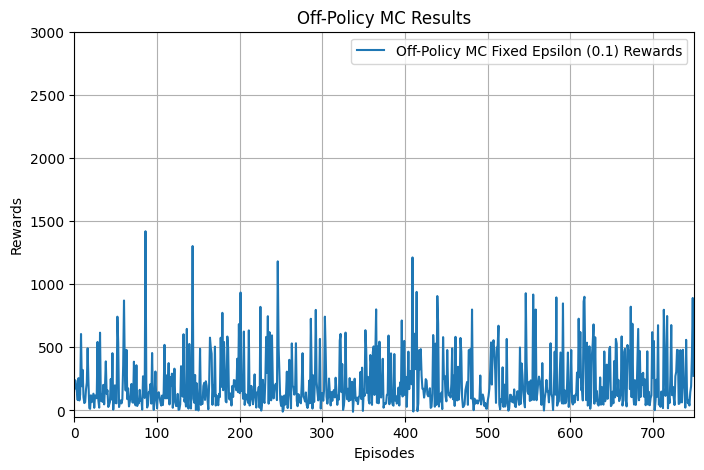

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.plot(mean_mc_rewards, label="Off-Policy MC Fixed Epsilon (0.1) Rewards")
plt.title(f"Off-Policy MC Results")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-50, 3000])
ax.set_xlim([0, episodes])

# Value Iteration

In [ ]:
P = world.get_transition_matrix() # Takes some time to execute

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_to_direction to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_to_direction` for environment variables or `env.get_wrapper_attr('action_to_direction')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_location to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_location` for environment variables or `env.get_wrapper_attr('agent_location')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.target_location to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.target_location`

In [ ]:
def value_iteration(tol=1e-2):
    num_states = world.observation_space.n
    num_actions = world.action_space.n

    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)

    for s in range(num_states):
        v = V[s]
        q_values = np.zeros(num_actions)
        for a in range(num_actions):
            for next_state, prob, reward, _, _, _ in P[s][a]: #next_state, prob, reward, terminated, truncated, {}
              q_values[a] += prob * (reward + gamma * V[next_state])
            best_action_value = np.max(q_values)
            V[s] = best_action_value
            policy[s] = np.argmax(q_values)

    return V, policy


V, optimal_policy = value_iteration()

In [ ]:
mean_vi_rewards = np.zeros(episodes)
max_vi_rewards = np.array([-np.inf] * episodes)

for j in range(iters):
  episode_rewards = []
  for i in range(episodes):
      episode_reward = 0
      state = world.reset(seed=int(seeds[j][i]))

      while True:
          if np.random.uniform(0, 1) < epsilons[i]:
              action = world.action_space.sample()
          else:
              action = int(optimal_policy[state])

          next_state, reward, done, truncated, _ = world.step(action)
          episode_reward += reward

          state = next_state

          if (done or truncated):
              break
      episode_rewards.append(episode_reward)
  max_vi_rewards = np.maximum(episode_rewards, max_vi_rewards)
  mean_vi_rewards = np.add(episode_rewards, mean_vi_rewards)

mean_vi_rewards *= 1 / iters

(0.0, 750.0)

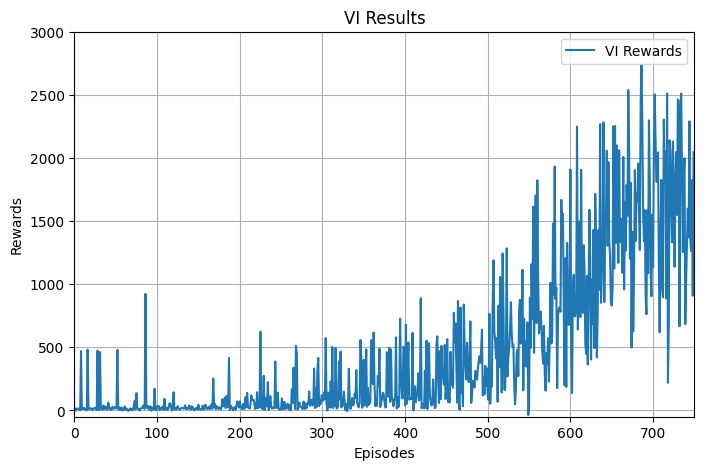

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.plot(mean_vi_rewards, label="VI Rewards")
plt.title(f"VI Results")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-50, 3000])
ax.set_xlim([0, episodes])

# MC & VI

In [ ]:
# Function to run Monte Carlo algorithm
def monte_carlo(env, num_episodes=750, gamma=0.9, alpha=0.1):
    num_states = env.observation_space.n
    V = np.zeros(num_states)  # Initialize state-value function

    for episode in range(num_episodes):
        state = env.reset(seed=int(seeds[0][episode]))
        episode_states = []
        episode_rewards = []

        while True:
            action = env.action_space.sample()  # Sample random action
            state, reward, done, truncated, _ = env.step(action)

            episode_states.append(state)
            episode_rewards.append(reward)

            if (done or truncated):
                break
            state = next_state

        G = 0
        for t in range(len(episode_states) - 1, -1, -1):
            G = gamma * G + episode_rewards[t]
            state = episode_states[t]
            V[state] = V[state] + alpha * (G - V[state])

    return V

learned_values = monte_carlo(world)

In [ ]:
P =  world.get_transition_matrix()
def value_iteration(env, learned_values, num_iterations=5000):
    num_states = env.observation_space.n
    V = np.copy(learned_values)  # Initialize with MC-learned values
    for _ in range(num_iterations):
        delta = 0
        for state in range(num_states):
            max_value = float('-inf')
            for action in range(env.action_space.n):
                action_value = 0
                for next_state, prob, reward, _, _, _ in P[state][action]:
                    action_value += prob * (reward + gamma * V[next_state])
                max_value = max(max_value, action_value)
            delta = max(delta, np.abs(max_value - V[state]))
            V[state] = max_value

        if delta < 1e-6:
            break

    return V

In [ ]:
mean_vi_mc_rewards = np.zeros(episodes)
max_vi_mc_rewards = np.array([-np.inf] * episodes)
for j in range(iters):
  episode_rewards = []

  for i in range(episodes):
    state, _ = world.reset(seed=int(seeds[j][i]))
    value_iteration_result = value_iteration(world, learned_values)

    episode_reward = 0
    done = truncated = False

    while not (done or truncated):
        if np.random.uniform(0, 1) < epsilons[i]:
            action = world.action_space.sample()
        else:
            action = np.argmax(value_iteration_result[state])
        next_state, reward, done, truncated, _ = world.step(action)
        episode_reward += reward
        state = next_state

    episode_rewards.append(episode_reward)
  max_vi_mc_rewards = np.maximum(episode_rewards, max_vi_mc_rewards)
  mean_vi_mc_rewards = np.add(episode_rewards, mean_vi_mc_rewards)

mean_vi_mc_rewards *= 1 / iters

<ipython-input-20-1a8ebcafa1e1>:12: RuntimeWarning: overflow encountered in double_scalars
  action_value += prob * (reward + gamma * V[next_state])
<ipython-input-20-1a8ebcafa1e1>:14: RuntimeWarning: invalid value encountered in double_scalars
  delta = max(delta, np.abs(max_value - V[state]))


(0.0, 750.0)

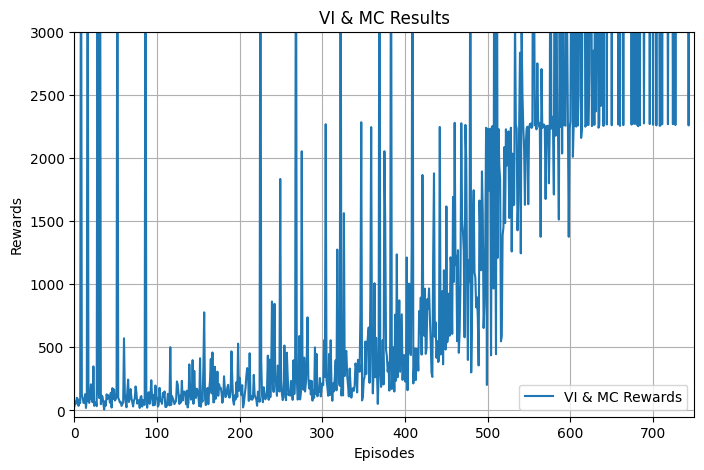

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.plot(max_vi_mc_rewards, label="VI & MC Rewards")
plt.title(f"VI & MC Results")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_ylim([-50, 3000])
ax.set_xlim([0, episodes])